In [1]:
for (fnm in list.files("rwwa_local", full.names = T)) source(fnm)
suppressMessages(library(extRemes))

In [2]:
# method to extract parameter estimates from Climate Explorer output
cx_par_ests <- function(parstring) {
    cols <- gsub("\\.\\.\\.", "",unlist(strsplit(paste0(unlist(strsplit(cx[grepl(parstring, cx)], "(<.+?>)")), collapse = ""), " +")))
    setNames(as.numeric(cols[length(cols) - (2:0)]), c("est", "lower", "upper"))
}

# How should independent shift+scale be modelled?

- linear scale parameter
- exponential scale parameter
- test against extRemes


- case study: SPI-OND from LA fire study
- synthetic data?
- compare to ClimExp results

# Compare different modelling approaches

In [116]:
fnm <- "EC-Earth_tmin.txt"; title <- "De Bilt TN1n"; varnm <- "tn1n"; covnm <- "gmst"; lower <- T
# fnm <- "EC-Earth_tmax.txt"; title <- "De Bilt TX1x"; varnm <- "tx1x"; covnm <- "gmst"; lower <- F

fig_nm <- paste0("ECE_de-bilt_",varnm,"_", covnm)

In [117]:
ts <- read.table(fnm, header = T, col.names = c("year", varnm))
gmst <- read.table("EC-Earth_gmst.txt", col.names = c("year", "gmst"))

df <- merge(gmst, ts)
df$gmst <- as.numeric(df$gmst)
df[,varnm] <- as.numeric(df[,varnm])
df$gmst <- df$gmst - df$gmst[df$year == 2025]

In [118]:
# extract parameters from Climate Explorer output
cx <- readLines(paste0("cx/cx_",fig_nm,"_shiftscale.txt"))
cx_ss_res <- sapply(list("mu0" = "mu;':</td><td> 2025", "sigma0" = "sigma;':</td><td> 2025", "alpha" = "alpha", "beta" = "beta", "xi" = "xi"), cx_par_ests)

# extract parameters from Climate Explorer output
cx <- readLines(paste0("cx/cx_",fig_nm,"_shift.txt"))
cx_s_res <- sapply(list("mu0" = "mu;':</td><td> 2025", "sigma0" = "sigma;':</td><td> 2025", "alpha" = "alpha", "xi" = "xi"), cx_par_ests)
cx_s_res <- cbind(cx_s_res, "beta" = NA)[,c("mu0", "sigma0", "alpha", "beta", "xi")]

# extract parameters from Climate Explorer output
cx <- readLines(paste0("cx/cx_",fig_nm,"_shiftscale-exp.txt"))
cx_ssexp_res <- sapply(list("mu0" = "mu;':</td><td> 2025", "sigma0" = "sigma;':</td><td> 2025", "alpha" = "alpha", "beta" = "beta", "xi" = "xi"), cx_par_ests)

In [119]:
# internal functions with different types of shift+scale fitting
mdl_shift <- fit_ns("gev", type = "shift", data = df, varnm = varnm, covnm = covnm, lower = lower)
mdl_shiftscale_linear <- fit_ns("gev", type = "shiftscale_linear", data = df, varnm = varnm, covnm = covnm, lower = lower)
mdl_shiftscale_exp <- fit_ns("gev", type = "shiftscale_exp", data = df, varnm = varnm, covnm = covnm, lower = lower)

In [120]:
# use extRemes methods to confirm
if (lower == T) { x <- -df[,varnm] } else { x <- df[,varnm] }

fevd_linear <- fevd(x, data = df, location.fun = ~gmst)
fevd_nophi <- fevd(x, data = df, location.fun = ~gmst, scale.fun = ~gmst)
fevd_phi <- fevd(x, data = df, location.fun = ~gmst, scale.fun = ~gmst, use.phi = T)

In [121]:
res <- rbind("shift_linear" = c(mdl_shift$par, "beta" = NA)[c(1,2,3,5,4)],
             "fevd_linear" = setNames(c(strip(fevd_linear), "beta" = NA)[c(1,3,2,5,4)], c("mu0", "sigma0", "mu1", "sigma1", "shape")),
             "ClimExp shift linear" = cx_s_res["est",],
             "shiftscale_linear" = mdl_shiftscale_linear$par,
             "fevd_nophi" = strip(fevd_nophi)[c("mu0", "sigma0", "mu1", "sigma1", "shape")],
             "ClimExp shiftscale linear" = cx_ss_res["est",],
             "shiftscale_exp" = mdl_shiftscale_exp$par,
             "fevd_phi" = strip(fevd_phi)[c("mu0", "phi0", "mu1", "phi1", "shape")],
             "ClimExp shiftscale exp" = cx_ssexp_res["est",]
             )
round(res, 5)
write.csv(res, paste0("res/pars_",fig_nm,".csv"))

,mu0,sigma0,alpha_gmst,beta,shape
shift_linear,-2.90216,2.08735,1.15393,NA,0.00407
fevd_linear,2.90216,2.08735,-1.15394,NA,0.00407
ClimExp shift linear,-2.90400,-2.09000,1.15400,NA,0.00300
shiftscale_linear,-2.91585,1.98675,1.20115,-0.25933,-0.01836
fevd_nophi,2.91583,1.98678,-1.20116,-0.25934,-0.01836
ClimExp shiftscale linear,-2.91600,-1.98600,1.20200,0.25900,-0.01800
shiftscale_exp,-2.90725,0.66007,1.20844,-0.14710,-0.02122
fevd_phi,2.90726,0.66007,-1.20844,-0.14710,-0.02123
ClimExp shiftscale exp,-2.90600,0.51700,1.20800,0.14700,-0.02200


In [122]:
prep_window(w = 6)

png(paste0("fig/fitted-model_",fig_nm,".png"), height = 300, width = 300*3); {
    prep_window(c(1,3))
    
    x <- unname(unlist(mdl_shiftscale_exp$cov))
    o <- order(x)

    plot(x[o], mdl_shiftscale_exp$x[o], main = title)
    lines(x[o], ns_pars(mdl_shiftscale_linear)$loc[o], lwd = 3, col = "blue")
    lines(x[o], ns_pars(mdl_shiftscale_exp)$loc[o], lwd = 3, col = "red3", lty = 2)
#     lines(x[o], findpars(fevd_nophi)$location[o], lwd = 3, col = "forestgreen", lty = 3)
#     lines(x[o], findpars(fevd_phi)$location[o], lwd = 3, col = "gold", lty = 4)

    rp <- 50
    lines(x[o], eff_return_level(mdl_shiftscale_exp, rp)[o], lwd = 1, col = "blue")
    lines(x[o], eff_return_level(mdl_shiftscale_linear, rp)[o], lwd = 1, col = "red3")
#     lines(x[o], erlevd(fevd_nophi, rp)[o], lwd = 2, col = "forestgreen", lty = 3)
#     lines(x[o], erlevd(fevd_phi, rp)[o], lwd = 2, col = "gold", lty = 3)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ylim = range(c(mdl_shiftscale_exp$x, eff_return_level(mdl_shiftscale_exp, 100)))

    # location parameter is the same
    plot(ns_pars(mdl_shiftscale_exp)$loc, ns_pars(mdl_shiftscale_linear)$loc, pch = 1, main = "Location & return level estimates",
         asp = 1, ylim = ylim, xlim = ylim, xlab = "scale = exp(a + bT)", ylab = "scale = a + bT")
#     points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_phi)$location)
#     points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_nophi)$location, pch = 4, col = "forestgreen")

#     legend("topleft", c("linear scale = a + bT", "FEVD with phi", "FEVD without phi"), pch =c(1,20,4), col = c("gold", "black", "forestgreen"))

    # return levels for moderately unusual events
    rp <- 10
    points(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "darkblue")
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")

    # return levels for extremes
    rp <- 100
    points(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "blue")
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")
    abline(0,1, lty = 2)
    
    legend("topleft", c("Location", "RL10", "RL100"), col = c("black", "darkblue", "blue"), pch = 20)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    plot(df$year, return_period(mdl_shiftscale_linear, eff_return_level(mdl_shiftscale_exp, 10)), ylim = c(0,120), xlab = "", ylab = "", main = "RP in linear-scaled fit"); abline(h = 10, lty = 2)
    points(df$year, return_period(mdl_shiftscale_linear, eff_return_level(mdl_shiftscale_exp, 50))); abline(h = 50, lty = 2)
    points(df$year, return_period(mdl_shiftscale_linear, eff_return_level(mdl_shiftscale_exp, 100))); abline(h = 100, lty = 2)
    
}; dev.off()

png 
  2

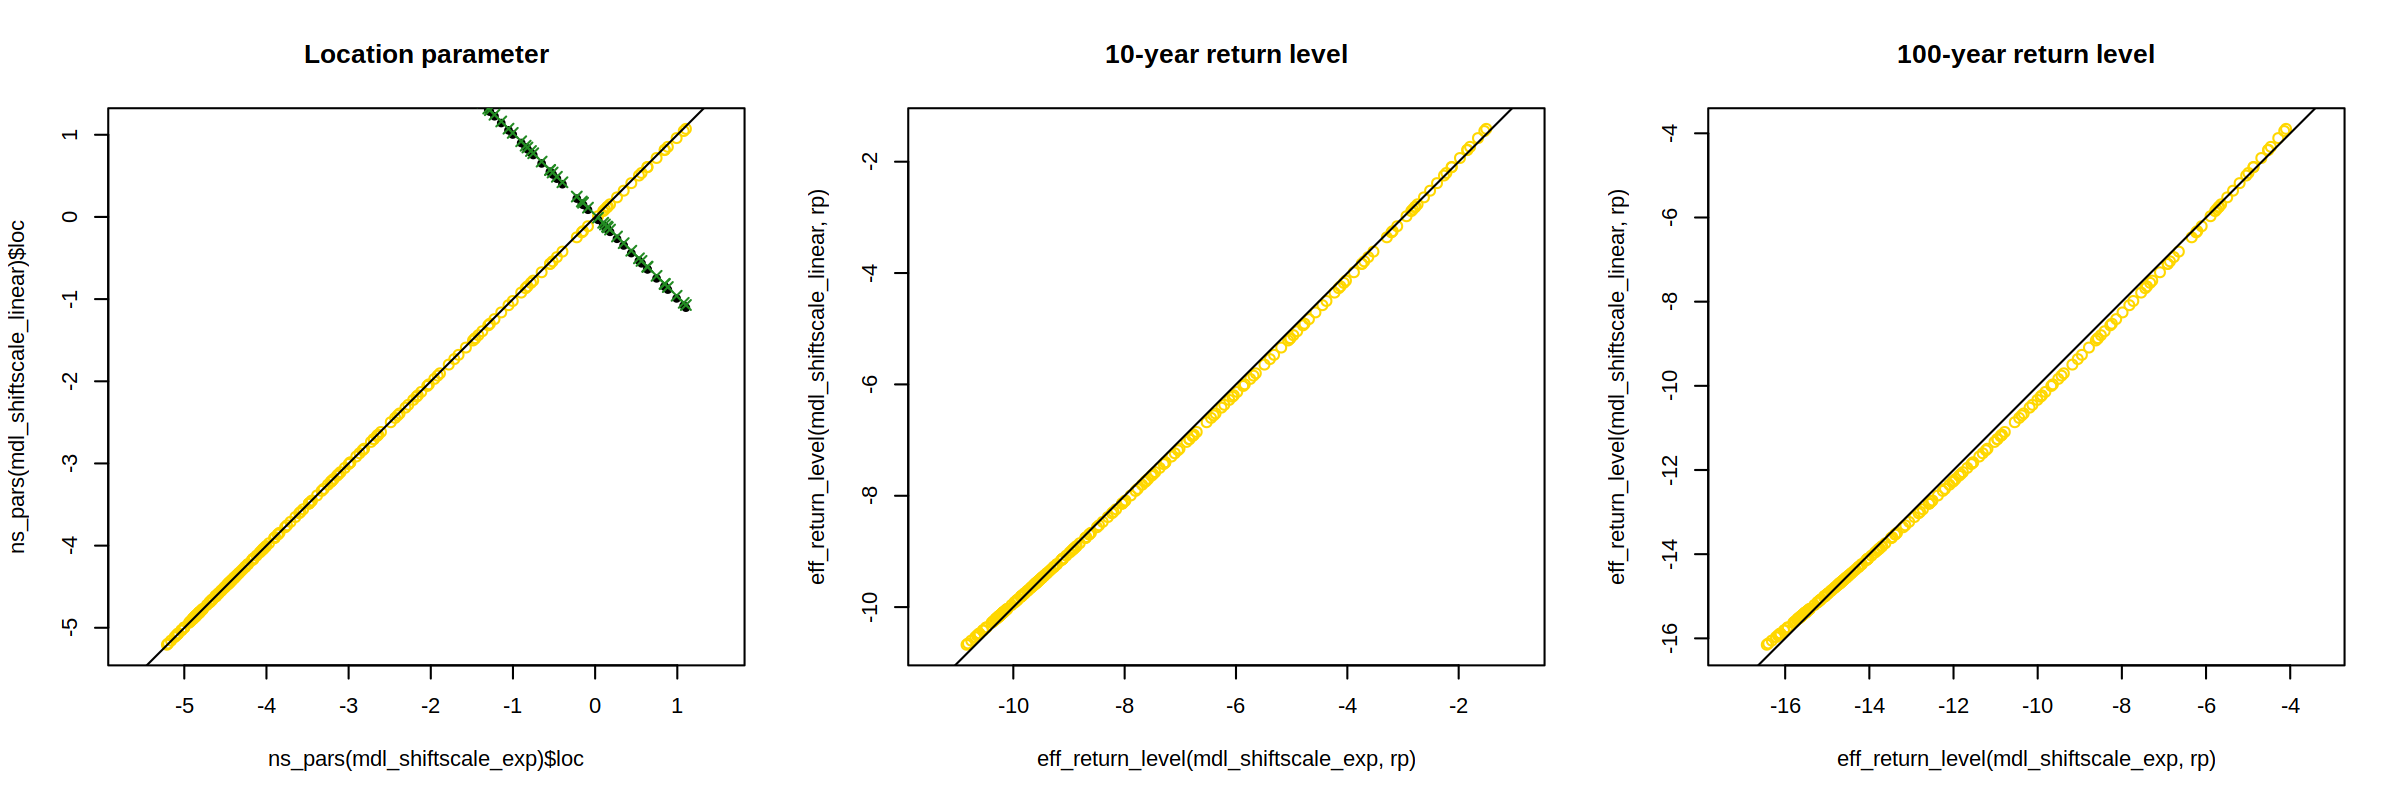

In [123]:
prep_window(c(1,3))

ylim = range(mdl_shiftscale_exp$x)

# location parameter is the same
plot(ns_pars(mdl_shiftscale_exp)$loc, ns_pars(mdl_shiftscale_linear)$loc, pch = 1, col = "gold", main = "Location parameter", asp = 1)
points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_phi)$location)
points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_nophi)$location, pch = 4, col = "forestgreen")
abline(0,1)

# return levels for moderately unusual events
rp <- 10
plot(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "gold", main = paste0(rp,"-year return level"), asp = 1)
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")
abline(0,1)

# return levels for extremes
rp <- 100
plot(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "gold", main = paste0(rp,"-year return level"), asp = 1)
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")
abline(0,1)